In [ ]:
!pip install py2neo

In [ ]:
!pip install stellargraph

In [ ]:
from py2neo.data import Node, Relationship
import py2neo

In [ ]:
graph = py2neo.Graph("bolt://0.tcp.ap.ngrok.io:19617/", auth=("neo4j", "randomstufF"))

In [ ]:
import pandas as pd
import os

import stellargraph as sg
from stellargraph.connector.neo4j import Neo4jGraphSAGENodeGenerator, Neo4jStellarGraph
from stellargraph.layer import GraphSAGE

import numpy as np
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

import time
%matplotlib inline


In [ ]:
# Authors
authors_df = graph.run(
    """
    MATCH (n:Author) RETURN n.name as name
    """).to_data_frame()

In [ ]:
(authors_df.drop_duplicates() == authors_df).drop_duplicates()

,name
0,True


In [ ]:
authors_df.head()

,name
0,Eun-Kyeong Kwon
1,Yong-Gu Cho
2,Kijoon Chae
3,Dominik Slezak
4,Anthony Brabazon


In [ ]:
# To give all the authors a identifier
dic_authors = {}
for i in range(len(authors_df)):
    dic_authors[authors_df['name'][i]] = i

In [ ]:
len(dic_authors)

63800

In [ ]:
dic_authors

{'Eun-Kyeong Kwon': 0,
 'Yong-Gu Cho': 1,
 'Kijoon Chae': 2,
 'Dominik Slezak': 3,
 'Anthony Brabazon': 4,
 "Michael O'Neill": 5,
 'Huijae Lee': 6,
 'Sang Bong Yoo': 7,
 'Christian Callegari': 8,
 'Stefano Giordano': 9,
 'Susanna Mannella': 10,
 'Michele Pagano': 11,
 'Mohamed Ahmed Abdelraheem': 12,
 'Julia Borghoff': 13,
 'Erik Zenner': 14,
 'Mathieu David': 15,
 'Amin Vahdat': 16,
 'Anna E. Bobkowska': 17,
 'Sondess Missaoui': 18,
 'Rim Faiz': 19,
 'Sanqiang Zhao': 20,
 'Wen Gao': 21,
 'Shiguang Shan': 22,
 'Baocai Yin': 23,
 'Giuseppe Attardi': 24,
 'Stefano Dei Rossi': 25,
 'Maria Simi': 26,
 'Ralf Münzenberger': 27,
 'Frank Slomka': 28,
 'Matthias Dörfel': 29,
 'Richard Hofmann': 30,
 'Qi Chen': 31,
 'Raymond W. Yeung': 32,
 'Christian Berger': 33,
 'Erik Dahlgren': 34,
 'Johan Grundén': 35,
 'Daniel Gunnarsson': 36,
 'Nadia Holtryd': 37,
 'Anmar Khazal': 38,
 'Mohamed Mustafa': 39,
 'Marina Papatriantafilou': 40,
 'Elad Michael Schiller': 41,
 'Christoph Steup': 42,
 'Viktor Swa

In [ ]:
co = graph.run(
    """
    MATCH p=(a)-[r:CO_AUTHOR_DIRECT]->(b) RETURN a.name as source,b.name as target 
    """).to_data_frame()

In [ ]:
print(co.shape)
co.head()

(120775, 2)


,source,target
0,Eun-Kyeong Kwon,Yong-Gu Cho
1,Eun-Kyeong Kwon,Kijoon Chae
2,Yong-Gu Cho,Kijoon Chae
3,Kijoon Chae,Hyun-Jung Na
4,Kijoon Chae,Ga-Jin Na


In [ ]:
cal_colab_direct_df = graph.run(
    """
    MATCH p=(a)-[r:CO_AUTHOR_DIRECT]->(b) RETURN a.name as source, b.name as target, r.collaborations
    """).to_data_frame()

In [ ]:
print(cal_colab_direct_df.shape)
cal_colab_direct_df.head()

(120775, 3)


,source,target,r.collaborations
0,Eun-Kyeong Kwon,Yong-Gu Cho,2
1,Eun-Kyeong Kwon,Kijoon Chae,2
2,Yong-Gu Cho,Kijoon Chae,2
3,Kijoon Chae,Hyun-Jung Na,1
4,Kijoon Chae,Ga-Jin Na,1


In [ ]:
cal_colab_direct_df[cal_colab_direct_df['source'] == 'Kijoon Chae']

,source,target,r.collaborations
3,Kijoon Chae,Hyun-Jung Na,1
4,Kijoon Chae,Ga-Jin Na,1
5,Kijoon Chae,Hayoung Oh,1
6,Kijoon Chae,Jung-Chan Na,1
7,Kijoon Chae,Youngsoo Kim,1
8,Kijoon Chae,Jungchan Nah,1
9,Kijoon Chae,Hyokyung Bahn,1
10,Kijoon Chae,Ok-Kyeung Kim,1
11,Kijoon Chae,Jiyoung Lim,2
12,Kijoon Chae,Myung-Jin Lee,1


In [ ]:
# Calculate total collaborations per author (direct)
colab_dic_direct = {}
for i in range(len(cal_colab_direct_df)):
    if dic_authors[cal_colab_direct_df['source'][i]] not in colab_dic_direct.keys():
        colab_dic_direct[dic_authors[cal_colab_direct_df['source'][i]]] = cal_colab_direct_df['r.collaborations'][i]
    else:
        colab_dic_direct[dic_authors[cal_colab_direct_df['source'][i]]] += cal_colab_direct_df['r.collaborations'][i]

    if dic_authors[cal_colab_direct_df['target'][i]]  not in colab_dic_direct.keys():
        colab_dic_direct[dic_authors[cal_colab_direct_df['target'][i]]] = cal_colab_direct_df['r.collaborations'][i]
    else:
        colab_dic_direct[dic_authors[cal_colab_direct_df['target'][i]]] += cal_colab_direct_df['r.collaborations'][i]

In [ ]:
print(len(colab_dic_direct))
# colab_dic_direct

60544


In [ ]:
cal_colab_cited_df = graph.run(
    """
    MATCH p=(a)-[r:CO_AUTHOR_CITED_FINAL]->(b) RETURN a.name as source, b.name as target, r.collaborations
    """).to_data_frame()

In [ ]:
print(cal_colab_cited_df.shape)
cal_colab_cited_df.head()

(60863, 3)


,source,target,r.collaborations
0,Raymond W. Yeung,Song-Nam Hong,3
1,Raymond W. Yeung,Steven Weber,12
2,Raymond W. Yeung,Vladimir Stankovic,3
3,Raymond W. Yeung,Neeharika Marukala,2
4,Raymond W. Yeung,Katherine Morrison,2


In [ ]:
cal_colab_cited_df[cal_colab_cited_df['source'] == 'Steven Weber']

,source,target,r.collaborations
9802,Steven Weber,Raymond Hall Yip Louie,2
9803,Steven Weber,Chun-Hung Liu,3
9804,Steven Weber,Junse Lee,2
9805,Steven Weber,Giovanni Luca Torrisi,2
9806,Steven Weber,Aaron B. Wagner,2
9807,Steven Weber,Namyoon Lee,5
9808,Steven Weber,Bertrand M. Hochwald,2
9809,Steven Weber,Dongning Guo,3
9810,Steven Weber,Jeffrey G. Andrews,3
9811,Steven Weber,Matthew R. McKay,2


In [ ]:
# Calculate total collaborations per author (cited)
colab_dic_cited = {}
for i in range(len(cal_colab_cited_df)):
    if dic_authors[cal_colab_cited_df['source'][i]] not in colab_dic_cited.keys():
        colab_dic_cited[dic_authors[cal_colab_cited_df['source'][i]]] = cal_colab_cited_df['r.collaborations'][i]
    else:
        colab_dic_cited[dic_authors[cal_colab_cited_df['source'][i]]] += cal_colab_cited_df['r.collaborations'][i]

    if dic_authors[cal_colab_cited_df['target'][i]]  not in colab_dic_cited.keys():
        colab_dic_cited[dic_authors[cal_colab_cited_df['target'][i]]] = cal_colab_cited_df['r.collaborations'][i]
    else:
        colab_dic_cited[dic_authors[cal_colab_cited_df['target'][i]]] += cal_colab_cited_df['r.collaborations'][i]

In [ ]:
print(len(colab_dic_cited))
# colab_dic_direct

8868


In [ ]:
colab_dic_direct == colab_dic_cited

False

In [ ]:
co['source'] = co['source'].apply(lambda x: dic_authors[x])
co['target'] = co['target'].apply(lambda x: dic_authors[x])

In [ ]:
co.head()
dff = co
del co

In [ ]:
print(dff.shape)
dff.head()

(120775, 2)


,source,target
0,0,1
1,0,2
2,1,2
3,2,59631
4,2,59630


In [ ]:
cora_feature_names = [f"f{i}" for i in range(2)]
print(cora_feature_names)

['f0', 'f1']


In [ ]:
cols = ['dir_colabs', 'cited_colabs']
idx = [i for i in range(len(dic_authors))]

In [ ]:
feat = pd.DataFrame(index=idx, columns=cols)

In [ ]:
feat.fillna(0, inplace=True)
feat.head()

,dir_colabs,cited_colabs
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [ ]:
for i in range(len(dic_authors)):
    if i in colab_dic_direct.keys():
        feat['dir_colabs'][i] = colab_dic_direct[i]
    else:
        feat['dir_colabs'][i] = 0
        
    if i in colab_dic_cited.keys():
        feat['cited_colabs'][i] = colab_dic_cited[i]
    else:
        feat['cited_colabs'][i] = 0

feat.head()

,dir_colabs,cited_colabs
0,4,0
1,4,0
2,16,0
3,19,0
4,15,0


In [ ]:
len(feat['cited_colabs'].drop_duplicates())

489

In [ ]:
# Normalise thee feaatures to feed into the moddel
dir_mean = feat['dir_colabs'].mean()
dir_max = feat['dir_colabs'].max()
dir_min = feat['dir_colabs'].min()

cit_mean = feat['cited_colabs'].mean()
cit_max = feat['cited_colabs'].max()
cit_min = feat['cited_colabs'].min()

In [ ]:
feat['dir_colabs'] = feat['dir_colabs'].apply(lambda x: ((x - dir_mean) / (dir_max - dir_min)))
feat['cited_colabs'] = feat['cited_colabs'].apply(lambda x: ((x - cit_mean) / (cit_max - cit_min)))

In [ ]:
feat.head(10)

,dir_colabs,cited_colabs
0,-0.001945,-0.001537
1,-0.001945,-0.001537
2,0.048055,-0.001537
3,0.060555,-0.001537
4,0.043888,-0.001537
5,-0.001945,-0.001537
6,-0.014445,-0.001537
7,0.023055,-0.001537
8,-0.001945,-0.001537
9,0.035555,-0.001537


In [ ]:

# fos features

In [ ]:
from stellargraph import StellarGraph

In [ ]:
sg = StellarGraph(feat,edges=dff)
# sg = StellarGraph(horizontal_feature,edges=dff)

In [ ]:
print(type(sg))
print(sg.info())

<class 'stellargraph.core.graph.StellarGraph'>
StellarGraph: Undirected multigraph
 Nodes: 63800, Edges: 120775

 Node types:
  default: [63800]
    Features: float32 vector, length 2
    Edge types: default-default->default

 Edge types:
    default-default->default: [120775]
        Weights: all 1 (default)
        Features: none


In [ ]:
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, HinSAGE, link_classification

In [ ]:
edge_splitter_test = EdgeSplitter(sg)

In [ ]:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.2, method="global", keep_connected=True
)

** Sampled 24155 positive and 24155 negative edges. **


In [ ]:
edge_splitter_train = EdgeSplitter(G_test)

In [ ]:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 9662 positive and 9662 negative edges. **


In [ ]:
print(G_train.info())

StellarGraph: Undirected multigraph
 Nodes: 63800, Edges: 86958

 Node types:
  default: [63800]
    Features: float32 vector, length 2
    Edge types: default-default->default

 Edge types:
    default-default->default: [86958]
        Weights: all 1 (default)
        Features: none


In [ ]:
print(G_test.info())

StellarGraph: Undirected multigraph
 Nodes: 63800, Edges: 96620

 Node types:
  default: [63800]
    Features: float32 vector, length 2
    Edge types: default-default->default

 Edge types:
    default-default->default: [96620]
        Weights: all 1 (default)
        Features: none


In [ ]:
batch_size = 20
epochs = 50

In [ ]:
num_samples = [20, 10]

In [ ]:
train_gen = GraphSAGELinkGenerator(G_train, batch_size, num_samples)

In [ ]:
train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True)

In [ ]:
test_gen = GraphSAGELinkGenerator(G_test, batch_size, num_samples)
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

In [ ]:
layer_sizes = [20, 20]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.3
)

In [ ]:
x_inp, x_out = graphsage.in_out_tensors()

In [ ]:
prediction = link_classification(
    output_dim=1, output_act="relu", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [ ]:
import tensorflow.keras as keras # DO NOT USE KERAS DIRECTLY
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

In [ ]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=["acc"],
)

In [57]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

2416/2416 [==============================] - 80s 33ms/step - loss: 0.7339 - acc: 0.7530

Train Set Metrics of the initial (untrained) model:
	loss: 0.7527
	acc: 0.7488

Test Set Metrics of the initial (untrained) model:
	loss: 0.7339
	acc: 0.7530


In [58]:
history = model.fit(train_flow, epochs=epochs, validation_data=test_flow, verbose=2)

Epoch 1/50
967/967 - 108s - loss: 0.5434 - acc: 0.7484 - val_loss: 0.6083 - val_acc: 0.7806
Epoch 2/50
967/967 - 107s - loss: 0.7940 - acc: 0.6122 - val_loss: 1.2903 - val_acc: 0.5503
Epoch 3/50
967/967 - 106s - loss: 0.5633 - acc: 0.7135 - val_loss: 0.7717 - val_acc: 0.7065
Epoch 4/50
967/967 - 104s - loss: 0.4895 - acc: 0.7712 - val_loss: 0.6920 - val_acc: 0.7525
Epoch 5/50
967/967 - 103s - loss: 0.5751 - acc: 0.7337 - val_loss: 1.0006 - val_acc: 0.6360
Epoch 6/50
967/967 - 104s - loss: 0.8151 - acc: 0.5918 - val_loss: 1.2498 - val_acc: 0.5670
Epoch 7/50
967/967 - 103s - loss: 0.6250 - acc: 0.6771 - val_loss: 0.8378 - val_acc: 0.6933
Epoch 8/50
967/967 - 104s - loss: 0.5514 - acc: 0.7369 - val_loss: 1.4428 - val_acc: 0.5347
Epoch 9/50
967/967 - 103s - loss: 0.6212 - acc: 0.6989 - val_loss: 0.7493 - val_acc: 0.7303
Epoch 10/50
967/967 - 103s - loss: 0.4950 - acc: 0.7689 - val_loss: 0.7510 - val_acc: 0.7410
Epoch 11/50
967/967 - 102s - loss: 0.5463 - acc: 0.7401 - val_loss: 0.7394 - va

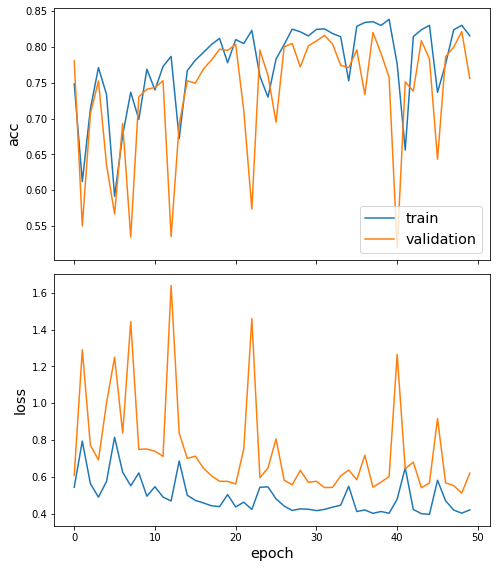

In [59]:
import stellargraph
stellargraph.utils.plot_history(history)

In [60]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

2416/2416 [==============================] - 80s 33ms/step - loss: 0.6202 - acc: 0.7573

Train Set Metrics of the trained model:
	loss: 0.6150
	acc: 0.7609

Test Set Metrics of the trained model:
	loss: 0.6202
	acc: 0.7573
